In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240509%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240509T092912Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D37344a0a6806baa3eaab93ee11da4a5a97ccc2459d55cef422c9f346cabeed1d137eb21013db11280964a06837b440fff371fd27a33d747dd85380530635acc41beeb47c432af38e384a788e07aadf4ea36b683fcf913e6aef447d23f21b26494f776d87cb3c642ec8ac587f8432f968d9abcaa0a244a8b85f194db24021fbadf718c1e2607baef4ea5f0d72ea092aca7f391c6a292299e36fa6f76797dd86b0c2cf02c82fcde80ea75071f36da15b7656155f711d3d44111601af318dcf9984385b12141b4772f287958b7b978b6bdbff6a022c5d642afbbeb33303e22f6b2883988fe39a0387004bf5b2ade503ab602216316f1572d63eb98002c3025e7de6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

Format of the file: age_gender_ethnicity_datetime

In [3]:
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
45_0_1_20170114033528807.jpg.chip.jpg


In [4]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

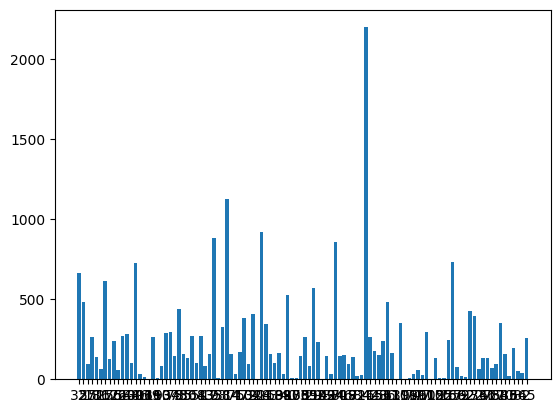

Max value: 99


In [5]:
import matplotlib.pyplot as plt
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

Gender: 0 Age: 46


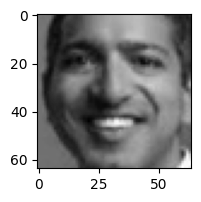

In [6]:
import matplotlib.pyplot as plt
def display(img):
    plt.figure(figsize =(2, 2))
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')

    plt.show()
idx = 500
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [7]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

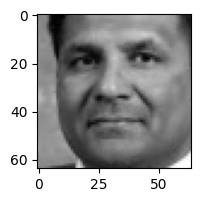

In [8]:
# pre processing
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [ ]:
print("Shape of image:",sample.shape)

Shape of image: (64, 64, 1)


In [ ]:
import keras
from keras.layers import *
from keras.models import *
from keras import backend as K

Using TensorFlow backend.


In [ ]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

In [ ]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 62, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 60, 60, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 30, 30, 64)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [ ]:
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 25, batch_size=128,shuffle = True)

Train on 18966 samples, validate on 4742 samples
Epoch 1/25
18966/18966 [==============================] - 9s 463us/step - loss: 0.7851 - dense_4_loss: 0.0905 - dense_10_loss: 0.6944 - dense_4_accuracy: 0.0136 - dense_10_accuracy: 0.5101 - val_loss: 0.7264 - val_dense_4_loss: 0.0367 - val_dense_10_loss: 0.6897 - val_dense_4_accuracy: 0.0325 - val_dense_10_accuracy: 0.5327
Epoch 2/25
18966/18966 [==============================] - 5s 247us/step - loss: 0.7024 - dense_4_loss: 0.0446 - dense_10_loss: 0.6593 - dense_4_accuracy: 0.0208 - dense_10_accuracy: 0.5636 - val_loss: 0.6001 - val_dense_4_loss: 0.0252 - val_dense_10_loss: 0.5752 - val_dense_4_accuracy: 0.0323 - val_dense_10_accuracy: 0.7879
Epoch 3/25
18966/18966 [==============================] - 5s 246us/step - loss: 0.6419 - dense_4_loss: 0.0386 - dense_10_loss: 0.6032 - dense_4_accuracy: 0.0220 - dense_10_accuracy: 0.7059 - val_loss: 0.5042 - val_dense_4_loss: 0.0235 - val_dense_10_loss: 0.4866 - val_dense_4_accuracy: 0.0323 - val

In [ ]:
model.save('data.h5')

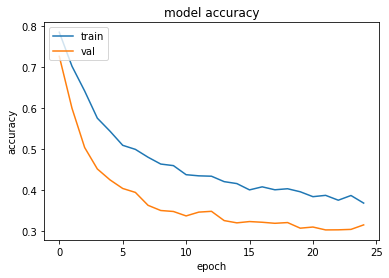

In [ ]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have already trained your model and stored it in a variable called 'model'
# Example:
# model = ... (your model definition and training code)

# Save the model
model.save("/content/drive/MyDrive/age_gen.h5")

In [13]:
from tensorflow.keras.models import load_model, save_model
# Load the model
loaded_model = load_model("/content/drive/MyDrive/age_gen.h5")

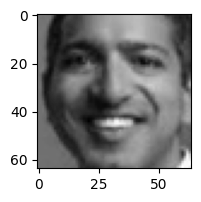

Actual Gender: Male Age: 46
1/1 [==============================] - 0s 83ms/step
Values: [array([[0.65198946]], dtype=float32), array([[0.01016025]], dtype=float32)] 
Predicted Gender: Male Predicted Age: Unknown


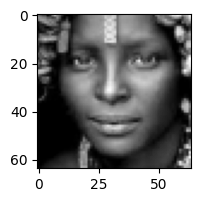

Actual Gender: Female Age: 28
1/1 [==============================] - 0s 95ms/step
Values: [array([[0.5340384]], dtype=float32), array([[0.84885335]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


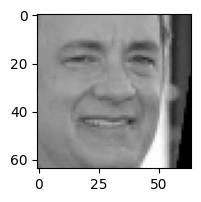

Actual Gender: Male Age: 55
1/1 [==============================] - 0s 45ms/step
Values: [array([[0.70656604]], dtype=float32), array([[0.00604976]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


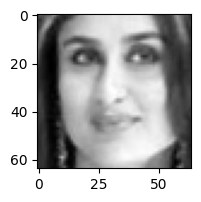

Actual Gender: Female Age: 30
1/1 [==============================] - 0s 44ms/step
Values: [array([[0.583562]], dtype=float32), array([[0.85013884]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


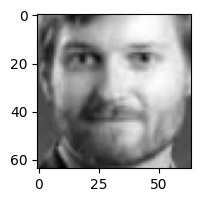

Actual Gender: Male Age: 32
1/1 [==============================] - 0s 44ms/step
Values: [array([[0.67577547]], dtype=float32), array([[0.00153395]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


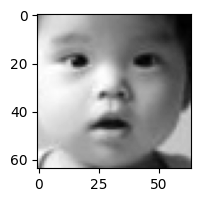

Actual Gender: Male Age: 2
1/1 [==============================] - 0s 56ms/step
Values: [array([[0.26532805]], dtype=float32), array([[0.47551778]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 0-18


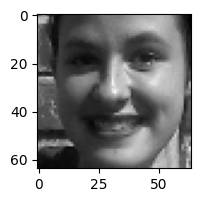

Actual Gender: Female Age: 19
1/1 [==============================] - 0s 28ms/step
Values: [array([[0.68009585]], dtype=float32), array([[0.85013884]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


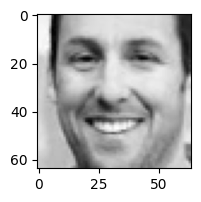

Actual Gender: Male Age: 30
1/1 [==============================] - 0s 28ms/step
Values: [array([[0.67654026]], dtype=float32), array([[0.00023059]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


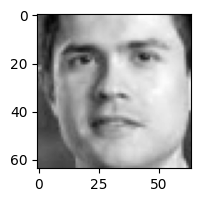

Actual Gender: Male Age: 30
1/1 [==============================] - 0s 29ms/step
Values: [array([[0.56617355]], dtype=float32), array([[0.00119812]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


In [16]:
def display(img):
    plt.figure(figsize=(2,2))
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"

def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = loaded_model.predict( np.array([ sample ]) )
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)


indexes = [500,59,80,2,4546,9,256,45,1]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)

In [18]:
import cv2
import csv
import numpy as np

# Load the pre-trained Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the video
video_capture = cv2.VideoCapture('/content/drive/MyDrive/face-demographics-walking_Ds5HH7rS.mp4')

# Check if the video was successfully loaded
if not video_capture.isOpened():
    print("Error: Could not open video file")
    exit()

# Initialize variables
face_id_count = 0
face_ids = {}

# Threshold for histogram similarity
threshold = 0.6  # Adjust as needed

# CSV file to store face ID, age, and gender
csv_file = open('face_data.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['ID', 'Age', 'Gender'])

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (int(video_capture.get(3)), int(video_capture.get(4))))

# Loop through the video frames
while True:
    # Read a frame from the video
    ret, frame = video_capture.read()

    # If the frame was not successfully read, break the loop
    if not ret:
        break

    # Convert the frame to grayscale for face detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Loop through each face found in the frame
    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Extract face region from the grayscale frame
        face_roi = gray_frame[y:y+h, x:x+w]

        # Check if the face matches any previously detected face
        found_match = False
        for face_id, (hist, _, age, gender) in face_ids.items():
            # Calculate histogram similarity
            similarity = cv2.compareHist(hist, cv2.calcHist([face_roi], [0], None, [256], [0,256]), cv2.HISTCMP_CORREL)
            if similarity > threshold:
                # If a match is found, assign the existing ID to the face
                face_id_assigned = face_id
                found_match = True
                break

        # If no match is found, assign a new ID to the face and create a histogram for it
        if not found_match:
            face_id_count += 1
            face_id_assigned = face_id_count
            face_hist = cv2.calcHist([face_roi], [0], None, [256], [0,256])
            # Initialize age and gender as None
            age, gender = None, None
            face_ids[face_id_assigned] = (face_hist, face_roi, age, gender)

            # Resize the face region to 64x64 pixels for age and gender estimation
            resized_face_roi = cv2.resize(face_roi, (64, 64))

            #age, gender = estimate_age_and_gender(resized_face_roi)
            resized_face_roi = resized_face_roi.reshape((resized_face_roi.shape[0],resized_face_roi.shape[1],1))
            sample = resized_face_roi/255
            val = loaded_model.predict( np.array([ sample ]) )
            age = get_age(val[0])
            gender = get_gender(val[1])

            # Update the age and gender for the new face
            # face_ids[face_id_assigned] = (face_hist, face_roi, age, gender)

            # Write the face ID, age, and gender to the CSV file
            csv_writer.writerow([face_id_assigned, age, gender])

        # Draw the ID label on the face
        cv2.putText(frame, f'ID: {face_id_assigned}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Draw age and gender labels if available
        if age is not None and gender is not None:
            cv2.putText(frame, f'Age: {age}, Gender: {gender}', (x, y - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the frame to the output video
    out.write(frame)

# Close the CSV file
csv_file.close()

# Release the video capture object and close all windows
video_capture.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 28ms/step
